In [13]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
file_path = "building_violations_2019_to_present.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,_id,case_no,ap_case_defn_key,status_dttm,status,code,value,description,violation_stno,violation_sthigh,...,contact_addr2,contact_city,contact_state,contact_zip,sam_id,latitude,longitude,location,geom_point_2249,geom_point_4326
0,3,V741124,1013,2024-02-14 15:06:00,Open,110.7,NaN,Periodic Inspections,463,NaN,...,NaN,CAMBRIDGE,MA,02138,11540.0,42.350930,-71.088211,"(42.35092955936467, -71.08821053015775)",0101000020C9080000FF7F2741EC6B2741BA80FA43EC87...,0101000020E61000002F8CC73DA5C551C0E2558242EB2C...
1,4,V741117,1013,2024-02-14 14:49:07,Open,1001.3.3,NaN,NaN,454,NaN,...,C/O GEORGE MAMAKOS,BOSTON,MA,02115,11490.0,42.351620,-71.087611,"(42.35161955885435, -71.08761052748115)",0101000020C90800007D83A3312E6D27419A56D0616A88...,0101000020E610000047942F699BC551C0EAF4A4DE012D...
2,5,V741114,1013,2024-02-14 14:27:35,Open,1001.3.2,NaN,Testing & Certification,108,NaN,...,NaN,MILTON LOWER MILL,MA,02187,90319.0,42.353140,-71.076811,"(42.35313954452243, -71.07681050027472)",0101000020C90800008341044FF7832741E8F8857D8689...,0101000020E6100000D6AA9676EAC451C0F75235AD332D...
3,6,V741111,1013,2024-02-14 14:12:33,Open,1001.3.2,NaN,Testing & Certification,401,NaN,...,NaN,BOSTON,MA,02115,167436.0,42.350472,-71.088478,"(42.350471929562474, -71.08847792164116)",0101000020C90800007F8AD14E5D6B2741C427DBB49887...,0101000020E61000007AF74C9FA9C551C084D1A143DC2C...
4,7,V741109,1013,2024-02-14 14:04:56,Open,1001.3.2,NaN,Testing & Certification,6,NaN,...,C/O LINDA J POLDOIAN,SUDBURY,MA,01776,168722.0,42.360209,-71.066605,"(42.36020935120114, -71.06660534861804)",0101000020C90800008053D1FF69992741E42F0C9B958E...,0101000020E61000006783144343C451C0A78F0B571B2E...


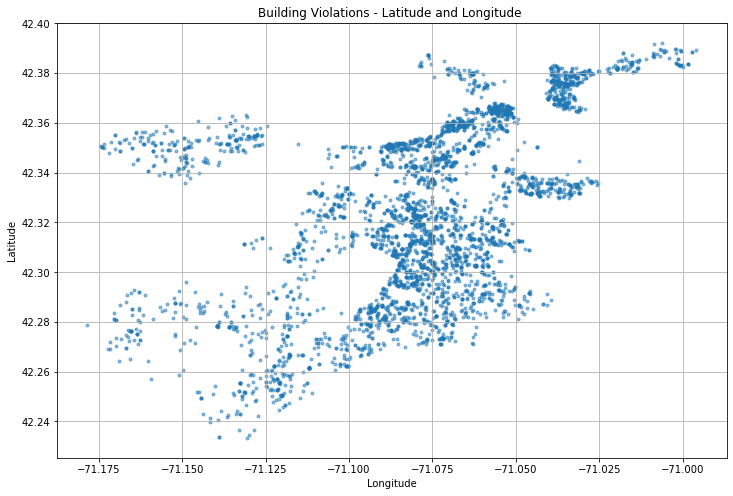

In [17]:
# Now we will cerate a cluster plot based off the lattitude and longitude

# This is needed to remove an outlier
df_filtered = df[df['latitude'] >= 42]


# Plotting latitude and longitude points
plt.figure(figsize=(12, 8))
plt.scatter(df_filtered['longitude'], df_filtered['latitude'], alpha=0.5, marker='.')
plt.title('Building Violations - Latitude and Longitude ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

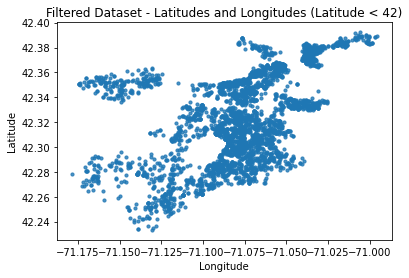

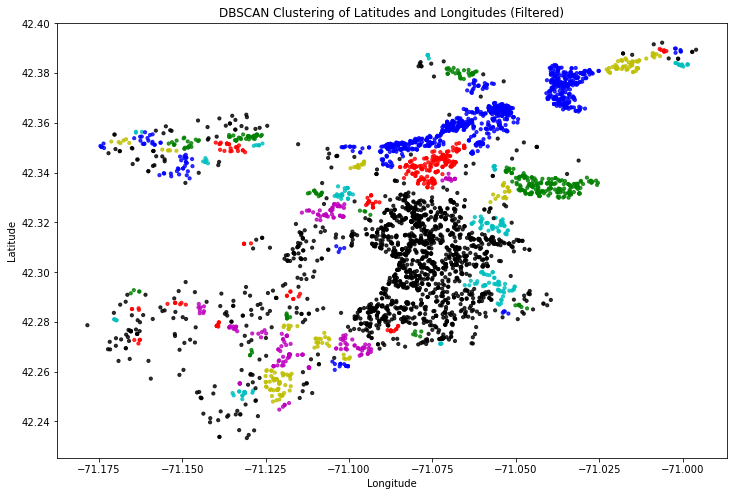

In [17]:
X = df_filtered[['latitude', 'longitude']].values

# Visualize the filtered dataset
plt.scatter(X[:, 1], X[:, 0], s=10, alpha=0.8)
plt.title('Filtered Dataset - Latitudes and Longitudes (Latitude < 42)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

class DBC():

    def __init__(self, dataset, min_pts, epsilon):
        self.dataset = dataset
        self.min_pts = min_pts
        self.epsilon = epsilon
        self.assignments = np.full(len(self.dataset), -1)

    def distance(self, i, j):
        # Modify the distance function for latitudes and longitudes
        lat1, lon1 = np.radians(self.dataset[i])
        lat2, lon2 = np.radians(self.dataset[j])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = 6371 * c  # Radius of the Earth in kilometers
        return distance
    
    def get_neighborhood(self, i):
        neighborhood = []
        for j in range(len(self.dataset)):
            if i != j and self.distance(i, j) <= self.epsilon:
                neighborhood.append(j)
        return neighborhood
    
    def is_unassigned(self, i):
        return self.assignments[i] == -1
    
    def get_unassigned_neighborhood(self, i):
        neighborhood = self.get_neighborhood(i)
        return [point for point in neighborhood if self.is_unassigned(point)]

    
    def is_core(self, i):
        return len(self.get_neighborhood(i)) >= self.min_pts
    
    def make_cluster(self, i, cluster_num):
        self.assignments[i] = cluster_num
        neighborhood_queue = self.get_unassigned_neighborhood(i)
        while neighborhood_queue:
            next_pt = neighborhood_queue.pop()
            if not self.is_unassigned(next_pt):
                continue
            self.assignments[next_pt] = cluster_num
            if self.is_core(next_pt):
                neighborhood_queue += self.get_neighborhood(next_pt)

        return

    def dbscan(self):
        cluster_num = 0
        for i in range(len(self.dataset)):
            if self.assignments[i] != -1:
                continue
            if self.is_core(i):
                self.make_cluster(i, cluster_num)
                cluster_num += 1
        return self.assignments

# Run DBSCAN on the latitudes and longitudes dataset (filtered)
clustering = DBC(X, 3, 0.2).dbscan()

# Visualize the clustered dataset
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 1], X[:, 0], color=colors[clustering].tolist(), s=10, alpha=0.8)
plt.title('DBSCAN Clustering of Latitudes and Longitudes (Filtered)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

/Users/john/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


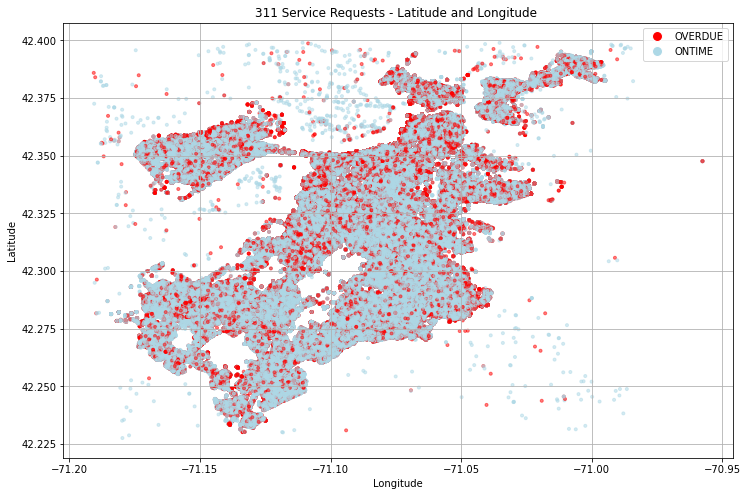

In [28]:
# Load the dataset
file_path2 = "311_2019_to_present.csv"
df2 = pd.read_csv(file_path2)


# This is needed to remove an outlier
df_filtered2 = df2[df2['latitude'] >= 42]

colors = np.where(df_filtered2['on_time'] == 'OVERDUE', 'red', 'lightblue')



# Plotting latitude and longitude points
plt.figure(figsize=(12, 8))
plt.scatter(df_filtered2['longitude'], df_filtered2['latitude'], alpha=0.5, marker='.', c = colors)
plt.title('311 Service Requests - Latitude and Longitude ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='OVERDUE'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='ONTIME')],
           loc='upper right')
plt.grid(True)
plt.show()

